In [1]:
import numpy as np
import rawpy as rp
import matplotlib.pyplot as plt
import image_conversions as imc
import os

In [2]:
max_level = 65535

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


def crop(im, crop_shape, gray=True):
    h0 = int(np.round( (im.shape[0] - crop_shape[0]) / 2 ))
    w0 = int(np.round( (im.shape[1] - crop_shape[1]) / 2 ))
    
    if gray:
        if len(im.shape) == 3 and im.shape[2] == 3:
            cropped_im = rgb2gray(im)[h0:h0+crop_shape[0], w0:w0+crop_shape[1]]
        elif len(im.shape) == 3 and im.shape[2] == 1:
            cropped_im = im[h0:h0+crop_shape[0], w0:w0+crop_shape[1],]
        else:
            cropped_im = im[h0:h0+crop_shape[0], w0:w0+crop_shape[1]]
    else:
        cropped_im = im[h0:h0+crop_shape[0], w0+w0+crop_shape[1],:]
        
    return cropped_im


def develop(fname, params, a, b):
    
    RAW_im = rp.imread(fname)
    noise = a*RAW_im.raw_image_visible[:,:]+b
    noise[noise < 0] = 0
    
    NEW_im = np.round(np.random.normal(loc=RAW_im.raw_image_visible[:,:], scale=np.sqrt(noise)))
    NEW_im[NEW_im < 0] = 0
    NEW_im[NEW_im > max_level] = max_level
    RAW_im.raw_image_visible[:,:] = NEW_im
    
    #(h,w) = RAW_im.raw_image_visible.shape
    
    rgb = RAW_im.postprocess(params)
    crop_shape = (264,264)
    
    gray = crop(rgb, crop_shape)
    
    return gray

In [3]:
ahddir = "AHD-set"
ahd8cov = "AHD-set/block8-covs/"
ahd8img = "AHD-set/block8-imgs/"
ahd24cov = "AHD-set/block24-covs/"
ahd24img = "AHD-set/block24-imgs/"

lindir = "LINEAR-set"
lin8cov = "LINEAR-set/block8-covs/"
lin8img = "LINEAR-set/block8-imgs/"
lin24cov = "LINEAR-set/block24-covs/"
lin24img = "LINEAR-set/block24-imgs/"

dirs = [ahddir, ahd8cov, ahd8img, ahd24cov, ahd24img, 
       lindir, lin8cov, lin8img, lin24cov, lin24img]
for d in dirs:
    if not os.path.isdir(d):
        os.makedirs(d)
    
base_img = "im.dng"
a = .6
b = 0
nb_img = 5
qmtx = np.ones((8,8))

paramsAHD = rp.Params(rp.DemosaicAlgorithm.AHD, half_size=False, four_color_rgb=False, 
                    use_camera_wb=True, use_auto_wb=False,user_wb=(1,1,1,1), 
                    output_color=rp.ColorSpace.raw, output_bps=16, 
                    user_flip=None, user_black=0, user_sat=None, 
                    no_auto_bright=True, auto_bright_thr=None, 
                    adjust_maximum_thr=0.0, bright=1.0, 
                    highlight_mode=rp.HighlightMode.Clip,  gamma=(1,1),
                    exp_shift=None, exp_preserve_highlights=0.0, no_auto_scale=False,
                    chromatic_aberration=None, bad_pixels_path=None,median_filter_passes=0)
, vmin=0, vmax=100
paramsLINEAR=rp.Params(rp.DemosaicAlgorithm.LINEAR, half_size=False, four_color_rgb=False, 
                    use_camera_wb=True, use_auto_wb=False,user_wb=(1,1,1,1), 
                    output_color=rp.ColorSpace.raw, output_bps=16, 
                    user_flip=None, user_black=0, user_sat=None, 
                    no_auto_bright=True, auto_bright_thr=None, 
                    adjust_maximum_thr=0.0, bright=1.0, 
                    highlight_mode=rp.HighlightMode.Clip,  gamma=(1,1),
                    exp_shift=None, exp_preserve_highlights=0.0, no_auto_scale=False,
                    chromatic_aberration=None, bad_pixels_path=None,median_filter_passes=0)

In [83]:
#Develop a dataset for the AHD pipeline
outpath8 = ahd8img
outpath24 = ahd24img

for i in range(nb_img):
    img = develop(base_img, paramsAHD, a, b)
    dct = imc.compute_dct_domain(img, qmtx)
    
    flat_block8 = imc.block_row_scan(dct, k=1)
    flat_block24 = imc.block_row_scan(dct, k=3)
    
    np.save(os.path.join(outpath8, str(i)), flat_block8)
    np.save(os.path.join(outpath24, str(i)), flat_block24)

In [84]:
#Develop a dataset for the LINEAR pipeline
outpath8 = lin8img
outpath24 = lin24img

for i in range(nb_img):
    img = develop(base_img, paramsLINEAR, a, b)
    dct = imc.compute_dct_domain(img, qmtx)
    
    flat_block8 = imc.block_row_scan(dct, k=1)
    flat_block24 = imc.block_row_scan(dct, k=3)
    
    np.save(os.path.join(outpath8, str(i)), flat_block8)
    np.save(os.path.join(outpath24, str(i)), flat_block24)

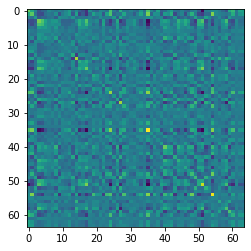

In [8]:
#Compute the covariance for the 8x8 AHD blocks
iptpath = ahd8img
outpath = ahd8cov

b, C = [], []
for fname in os.listdir(iptpath):
    f = np.load(os.path.join(iptpath, fname))
    b.append(f)
b = np.asarray(b)

for i in range(b.shape[1]):
    for j in range(b.shape[2]):
        C.append(np.cov(b[:,i,j,:].T,))
C = np.asarray(C)
plt.imshow(C[0])
plt.show()
np.save(os.path.join(outpath, "cov-mtx"), C)

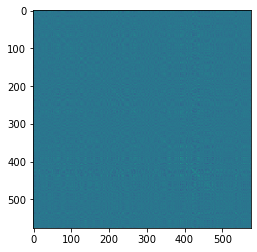

In [9]:
#Compute the covariance for the 24x24 AHD blocks
iptpath = ahd24img
outpath = ahd24cov

b, C = [], []
for fname in os.listdir(iptpath):
    f = np.load(os.path.join(iptpath, fname))
    b.append(f)
b = np.asarray(b)

for i in range(b.shape[1]):
    for j in range(b.shape[2]):
        C.append(np.cov(b[:,i,j,:].T))
C = np.asarray(C)
plt.imshow(C[0])
plt.show()
np.save(os.path.join(outpath, "cov-mtx"), C)

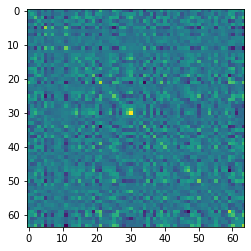

In [10]:
#Compute the covariance for the 8x8 LINEAR blocks
iptpath = lin8img
outpath = lin8cov

b, C = [], []
for fname in os.listdir(iptpath):
    f = np.load(os.path.join(iptpath, fname))
    b.append(f)
b = np.asarray(b)

for i in range(b.shape[1]):
    for j in range(b.shape[2]):
        C.append(np.cov(b[:,i,j,:].T))
C = np.asarray(C)
plt.imshow(C[0])
plt.show()
np.save(os.path.join(outpath, "cov-mtx"), C)

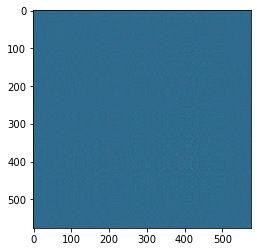

In [11]:
#Compute the covariance for the 24x24 LINEAR blocks
iptpath = lin24img
outpath = lin24cov

b, C = [], []
for fname in os.listdir(iptpath):
    f = np.load(os.path.join(iptpath, fname))
    b.append(f)
b = np.asarray(b)

for i in range(b.shape[1]):
    for j in range(b.shape[2]):
        C.append(np.cov(b[:,i,j,:].T))
C = np.asarray(C)
plt.imshow(C[0])
plt.show()
np.save(os.path.join(outpath, "cov-mtx"), C)

In [28]:
rvd = np.arange(16*16).reshape((16,16))

In [29]:
frvd = imc.block_row_scan(rvd, k=1)

In [12]:
#print(frvd.shape)
#print(frvd)
#print(rvd)

In [38]:
img = np.zeros((16,16)).astype(np.float32)
for i in range(frvd.shape[0]):
    for j in range(frvd.shape[1]):
         img[8*i:8*(i+1), 8*j:8*(j+1)] = frvd[i,j].reshape((8,8))

In [11]:
#print(img)

In [40]:
os.makedirs("AHD-set/imgs/")
os.makedirs("LINEAR-set/imgs/")

In [13]:
"""
for f in os.listdir(ahd8img):
    vec = np.load(os.path.join(ahd8img, f))
    print(vec.shape)
    full_img = np.zeros((264, 264))
    for i in range(vec.shape[0]):
        for j in range(vec.shape[1]):
            full_img[8*i:8*(i+1), 8*j:8*(j+1)] = vec[i,j].reshape((8,8))
            np.save(os.path.join("AHD-set/imgs/", f), full_img.astype(np.float32))
            spat = imc.compute_spatial_domain(full_img, qmtx) / r
"""

'\nfor f in os.listdir(ahd8img):\n    vec = np.load(os.path.join(ahd8img, f))\n    print(vec.shape)\n    full_img = np.zeros((264, 264))\n    for i in range(vec.shape[0]):\n        for j in range(vec.shape[1]):\n            full_img[8*i:8*(i+1), 8*j:8*(j+1)] = vec[i,j].reshape((8,8))\n            np.save(os.path.join("AHD-set/imgs/", f), full_img.astype(np.float32))\n            spat = imc.compute_spatial_domain(full_img, qmtx) / r\n'

In [90]:
for f in os.listdir(lin8img):
    vec = np.load(os.path.join(lin8img, f))
    print(vec.shape)
    full_img = np.zeros((264, 264))
    for i in range(vec.shape[0]):
        for j in range(vec.shape[1]):
            full_img[8*i:8*(i+1), 8*j:8*(j+1)] = vec[i,j].reshape((8,8))
            np.save(os.path.join("LINEAR-set/imgs/", f), full_img.astype(np.float32))
            #vec = imc.compute_dct_domain(imc.compute_spatial_domain(np.load(os.path.join(lin8img, f)), qmtx) / (2**16-1) * 255, qmtx).astype(np.float32)



(33, 33, 64)
(33, 33, 64)
(33, 33, 64)
(33, 33, 64)
(33, 33, 64)


In [10]:
#test = np.load("AHD-set/imgs/0.npy")

In [9]:
#spatial = imc.compute_spatial_domain(test, np.ones((1,1)))

In [4]:
#plt.imshow(spatial)

In [8]:
#spatial = spatial / (2**16-1) * 256

In [5]:
#plt.imshow(spatial)

In [7]:
#rescaled = imc.compute_dct_domain(imc.compute_spatial_domain(test, np.ones((8,8))) / (2**16-1) * 256, np.ones((8,8)))

In [6]:
#plt.imshow(rescaled)

In [4]:
#os.makedirs("AHD-set/imgs/")
#os.makedirs("LINEAR-set/imgs/")
r = (2**16-1) * 255
repo = os.listdir(lin8img)
for f in repo:
    vec = np.load(os.path.join(lin8img, f))
    print(vec.shape)
    full_img = np.zeros((264, 264))
    for i in range(vec.shape[0]):
        for j in range(vec.shape[1]):
            full_img[8*i:8*(i+1), 8*j:8*(j+1)] = vec[i,j].reshape((8,8))
    np.save(os.path.join("LINEAR-set/imgs/", f), full_img.astype(np.float32)) #Image complète dans un nouveau repo
    spat = imc.compute_spatial_domain(full_img, qmtx) / r
    dct = imc.compute_dct_domain(spat, qmtx)
    np.save(os.path.join(lin8img, f), imc.block_row_scan(dct, k=1)) #On écrase avec les modifications            
            
repo = os.listdir(ahd8img)
for f in repo:
    vec = np.load(os.path.join(ahd8img, f))
    print(vec.shape)
    full_img = np.zeros((264, 264))
    for i in range(vec.shape[0]):
        for j in range(vec.shape[1]):
            full_img[8*i:8*(i+1), 8*j:8*(j+1)] = vec[i,j].reshape((8,8))
    np.save(os.path.join("AHD-set/imgs/", f), full_img.astype(np.float32)) #Image complète dans un nouveau repo
    spat = imc.compute_spatial_domain(full_img, qmtx) / r
    dct = imc.compute_dct_domain(spat, qmtx)
    np.save(os.path.join(ahd8img, f), imc.block_row_scan(dct, k=1)) #On écrase avec les modifications


(33, 33, 64)
(33, 33, 64)
(33, 33, 64)
(33, 33, 64)
(33, 33, 64)
(33, 33, 64)
(33, 33, 64)
(33, 33, 64)
(33, 33, 64)
(33, 33, 64)


In [87]:
vec = np.load(os.path.join(lin8img, "0.npy"))
vec = imc.block_row_scan(vec, k=1)
np.save(os.path.join(lin8img, "0.npy"), vec)

In [33]:
#Mesure de distances entre les covariances
cov_ahd = np.load(os.path.join(ahd8cov, "cov-mtx.npy"))
cov_lin = np.load(os.path.join(lin8cov, "cov-mtx.npy"))

In [60]:
from numpy import trace, log, dot, exp
from numpy.linalg import inv, det, slogdet
import pyriemann.utils.distance as dist

In [77]:
def dkl(cov1, cov2):
    dim = cov1.shape[0]
    s1, d1 = slogdet(cov1)
    s2, d2 = slogdet(cov2)
    logdet = log(np.abs(s2/s1)*exp(d2-d1))
    #print('logdet = ', logdet)
    kl = trace(dot(inv(cov2), cov1)) - dim + logdet
    return .5 * kl 


def block_dkl(cov1, cov2):
    if not cov1.shape == cov2.shape:
        print("Input shapes missmatch. Can not compute")
        return None
    n = cov1.shape[0]
    s = 0
    for i in range(n):
        s += dkl(cov1[i,:,:], cov2[i,:,:])
    return s

In [78]:
covdiv = dkl(cov_ahd[0,:,:], cov_lin[0,:,:])
print(covdiv)
full_covdiv = block_dkl(cov_ahd, cov_lin)
print(full_covdiv)

1.2747621992948368e+17
-2.8095199709568964e+21


In [63]:
print(dist.distance(cov_ahd[0], cov_lin[0], metric='euclid'))

245116.1796445344


<function matplotlib.pyplot.show(*args, **kw)>

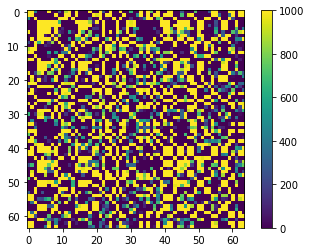

In [64]:
#plt.imshow(cov_ahd[0], vmin=0, vmax=100)
plt.imshow(cov_ahd[0], vmin=0, vmax=1000)
plt.colorbar()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

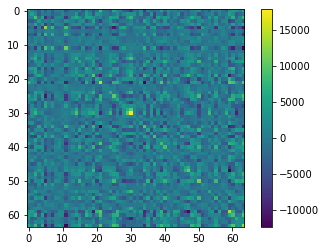

In [38]:
#plt.imshow(cov_lin[0], vmin=0, vmax=1000)
plt.imshow(cov_lin[0])
plt.colorbar()
plt.show

In [39]:
print(np.amax(cov_lin))
print(np.amax(cov_ahd))

138057.83481222295
125782.24256348237


In [47]:
lin0 = cov_lin[0]
ahd0 = cov_ahd[0]
sl, dl = np.linalg.slogdet(ahd0)
sa, da = np.linalg.slogdet(lin0)

In [48]:
print(sl, dl)
print(sa, da)

1.0 -1608.7919475512583
-1.0 -1594.4656450197251


In [55]:
d = np.abs(sl * np.exp(dl) / (sa*np.exp(da)))
print(d)

nan


<ipython-input-55-ccd561bc2b37>:1: RuntimeWarning: invalid value encountered in double_scalars
  d = np.abs(sl * np.exp(dl) / (sa*np.exp(da)))


In [56]:
d = sl/sa*np.exp(dl-da)
print(d)

-6.000201904579425e-07


In [57]:
print(np.log(np.abs(d)))

-14.326302531533202
